In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# 读取数据
dengue_data = gpd.read_file('Rawdata/dengue_surveillance.json')
density_data = gpd.read_file('Rawdata/density_2022.json')

# 查看数据基本情况
print("Dengue Surveillance Data Info:")
print(dengue_data.info())
print("\nFirst few rows of dengue data:")
print(dengue_data.head())

print("\nDensity Data Info:")
print(density_data.info())
print("\nFirst few rows of density data:")
print(density_data.head())

Dengue Surveillance Data Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OGR_FID     2368 non-null   int32   
 1   OPS_AREA    2368 non-null   object  
 2   OPS_AREA_C  2368 non-null   object  
 3   DISTRICT    2368 non-null   object  
 4   DISTRICT_C  2368 non-null   object  
 5   LOCATION    2368 non-null   object  
 6   LOCATION_C  2368 non-null   object  
 7   PERIOD      2368 non-null   object  
 8   AGI         2368 non-null   float64 
 9   ADI         2368 non-null   float64 
 10  geometry    2368 non-null   geometry
dtypes: float64(2), geometry(1), int32(1), object(7)
memory usage: 194.4+ KB
None

First few rows of dengue data:
   OGR_FID                             OPS_AREA OPS_AREA_C          DISTRICT  \
0        1  Hong Kong Island & Outlying Islands     香港島及離島  Central/ Western   
1        2  Hong Kong Island & Out

In [4]:
# 查看两个数据集的CRS
print("Dengue data CRS:", dengue_data.crs)
print("Density data CRS:", density_data.crs)

# 如果需要，统一CRS
dengue_data = dengue_data.to_crs(density_data.crs)

Dengue data CRS: EPSG:2326
Density data CRS: EPSG:2326


In [5]:
# 转换PERIOD为datetime格式
dengue_data['PERIOD'] = pd.to_datetime(dengue_data['PERIOD'])

# 查看时间范围
print("Time range:", dengue_data['PERIOD'].min(), "to", dengue_data['PERIOD'].max())

# 按时间排序
dengue_data = dengue_data.sort_values('PERIOD')

# 检查时间间隔
time_diff = dengue_data['PERIOD'].diff().value_counts()
print("\nTime intervals between measurements:")
print(time_diff)

Time range: 2021-09-01 00:00:00 to 2024-09-01 00:00:00

Time intervals between measurements:
PERIOD
0 days     2331
31 days      21
30 days      12
28 days       2
29 days       1
Name: count, dtype: int64


Districts in dengue data: 19
Districts in density data: 18

Districts not matching:
In dengue but not in density: {'Yau Tsim', 'Central/ Western', 'Mong Kok', 'Wanchai'}
In density but not in dengue: {'Wan Chai', 'Central and Western', 'Yau Tsim Mong'}


<Figure size 1200x600 with 0 Axes>

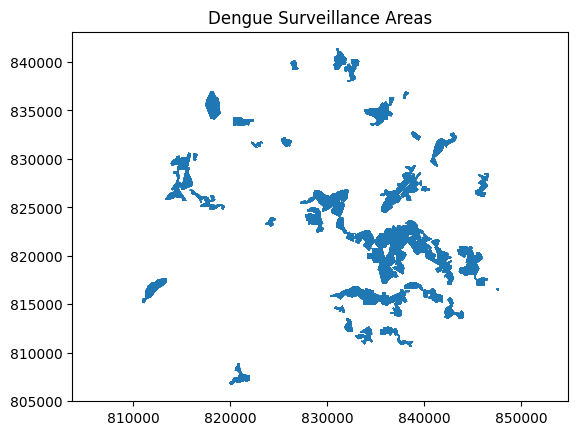

In [6]:
# 检查地区匹配情况
dengue_districts = set(dengue_data['DISTRICT'].unique())
density_districts = set(density_data['DC_ENG'].unique())

print("Districts in dengue data:", len(dengue_districts))
print("Districts in density data:", len(density_districts))
print("\nDistricts not matching:")
print("In dengue but not in density:", dengue_districts - density_districts)
print("In density but not in dengue:", density_districts - dengue_districts)

# 可视化地区分布
plt.figure(figsize=(12, 6))
dengue_data.plot()
plt.title('Dengue Surveillance Areas')
plt.axis('equal')
plt.show()

In [7]:
# 创建地区名称映射字典
district_mapping = {
    'Central/ Western': 'Central and Western',
    'Wanchai': 'Wan Chai',
    'Yau Tsim': 'Yau Tsim Mong',
    'Mong Kok': 'Yau Tsim Mong'  # Mong Kok也映射到Yau Tsim Mong
}

# 应用映射到dengue数据
dengue_data['DISTRICT'] = dengue_data['DISTRICT'].replace(district_mapping)

# 对于Mong Kok和Yau Tsim的数据，需要合并它们的指标
# 按PERIOD和合并后的DISTRICT分组，计算平均值
dengue_data = dengue_data.groupby(['PERIOD', 'DISTRICT', 'DISTRICT_C'], as_index=False).agg({
    'AGI': 'mean',
    'ADI': 'mean',
    'OGR_FID': 'first',  # 保留第一个FID
    'OPS_AREA': 'first',
    'OPS_AREA_C': 'first',
    'LOCATION': 'first',
    'LOCATION_C': 'first',
    'geometry': 'first'  # 对于geometry，我们暂时保留第一个
})

# 再次检查地区匹配情况
dengue_districts = set(dengue_data['DISTRICT'].unique())
density_districts = set(density_data['DC_ENG'].unique())

print("Districts in dengue data:", len(dengue_districts))
print("Districts in density data:", len(density_districts))
print("\nDistricts not matching:")
print("In dengue but not in density:", dengue_districts - density_districts)
print("In density but not in dengue:", density_districts - dengue_districts)

# 查看处理后的数据分布
print("\nProcessed district counts:")
print(dengue_data['DISTRICT'].value_counts())

Districts in dengue data: 18
Districts in density data: 18

Districts not matching:
In dengue but not in density: set()
In density but not in dengue: set()

Processed district counts:
DISTRICT
Yau Tsim Mong          74
Central and Western    37
Eastern                37
Islands                37
Kwai Tsing             37
Kowloon City           37
North                  37
Sai Kung               37
Sha Tin                37
Kwun Tong              37
Sham Shui Po           37
Southern               37
Tsuen Wan              37
Tai Po                 37
Tuen Mun               37
Wan Chai               37
Wong Tai Sin           37
Yuen Long              37
Name: count, dtype: int64


In [8]:
# 合并数据集
merged_data = dengue_data.merge(
    density_data[['DC_ENG', 'POPN_D', 'LA', 'MYPOPN_LAND']], 
    left_on='DISTRICT', 
    right_on='DC_ENG',
    how='left'
)

# 添加时间特征
merged_data['month'] = merged_data['PERIOD'].dt.month
merged_data['season'] = pd.cut(merged_data['month'], 
                             bins=[0,3,6,9,12], 
                             labels=['春','夏','秋','冬'])

# 标准化数值特征
scaler = StandardScaler()
numeric_features = ['AGI', 'ADI', 'POPN_D', 'LA']
merged_data[numeric_features] = scaler.fit_transform(merged_data[numeric_features])

# 检查处理后的数据
print("Processed data info:")
print(merged_data.info())
print("\nSample of processed data:")
print(merged_data.head())

Processed data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   PERIOD       703 non-null    datetime64[ns]
 1   DISTRICT     703 non-null    object        
 2   DISTRICT_C   703 non-null    object        
 3   AGI          703 non-null    float64       
 4   ADI          703 non-null    float64       
 5   OGR_FID      703 non-null    int32         
 6   OPS_AREA     703 non-null    object        
 7   OPS_AREA_C   703 non-null    object        
 8   LOCATION     703 non-null    object        
 9   LOCATION_C   703 non-null    object        
 10  geometry     703 non-null    geometry      
 11  DC_ENG       703 non-null    object        
 12  POPN_D       703 non-null    float64       
 13  LA           703 non-null    float64       
 14  MYPOPN_LAND  703 non-null    float64       
 15  month        703 non-null    int32  

让我详细解释每个列的含义：

时间和地区标识：

PERIOD: 监测时间点（日期格式）
DISTRICT/DISTRICT_C: 地区名称（英文/中文）
OGR_FID: 空间要素的唯一标识符
登革热监测指标：

AGI (Area Gravidtrap Index): 诱蚊器指数(%)
反映特定区域内诱蚊器捕获蚊子的情况
ADI (Area Density Index): 密度指数
反映蚊子密度的指标
区域描述：

OPS_AREA/OPS_AREA_C: 行政区域（英文/中文）
LOCATION/LOCATION_C: 具体监测地点（英文/中文）
geometry: 地理空间数据（包含地理坐标和形状信息）
人口统计数据：

POPN_D: 人口密度（每平方公里人数）
LA: 土地面积（平方公里）
MYPOPN_LAND: 年中人口数（千人）
时间特征（派生列）：

month: 月份（1-12）
season: 季节分类（春夏秋冬）

Missing values:
PERIOD         0
DISTRICT       0
DISTRICT_C     0
AGI            0
ADI            0
OGR_FID        0
OPS_AREA       0
OPS_AREA_C     0
LOCATION       0
LOCATION_C     0
geometry       0
DC_ENG         0
POPN_D         0
LA             0
MYPOPN_LAND    0
month          0
season         0
dtype: int64

Numerical features statistics:
                AGI           ADI        POPN_D            LA
count  7.030000e+02  7.030000e+02  7.030000e+02  7.030000e+02
mean  -2.021459e-17  2.021459e-17 -5.022061e-17  1.800362e-17
std    1.000712e+00  1.000712e+00  1.000712e+00  1.000712e+00
min   -7.961008e-01 -1.563178e+00 -1.082927e+00 -8.872239e-01
25%   -7.204270e-01 -8.888425e-01 -8.797174e-01 -8.343969e-01
50%   -3.476634e-01  4.193687e-01 -3.259047e-01 -6.012231e-01
75%    3.415289e-01  7.295631e-01  1.160503e+00  1.258919e+00
max    5.695031e+00  2.887437e+00  2.078466e+00  2.176221e+00


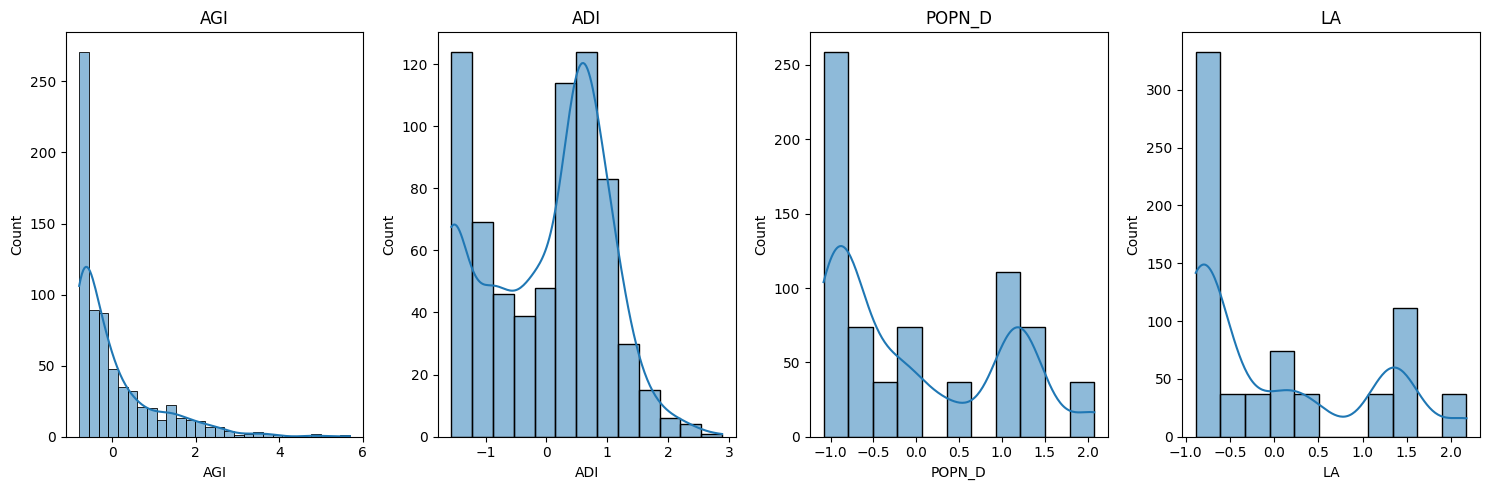

In [9]:
# 检查缺失值
print("Missing values:")
print(merged_data.isnull().sum())

# 基本统计描述
print("\nNumerical features statistics:")
print(merged_data[numeric_features].describe())

# 可视化特征分布
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 4, i)
    sns.histplot(merged_data[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [11]:
# 1. 保存完整的处理后数据（包含地理信息）
merged_data.to_pickle('Data/processed_dengue_data_full.pkl')

# 2. 准备和保存用于VAE的数据数组
def prepare_vae_data(merged_data, time_window=6):
    # 按地区和时间排序
    merged_data = merged_data.sort_values(['DISTRICT', 'PERIOD'])
    
    # 创建时间窗口特征
    districts = merged_data['DISTRICT'].unique()
    
    # 选择用于VAE的特征
    features = ['AGI', 'ADI', 'POPN_D', 'LA', 'month']
    # 将season转换为数值
    merged_data['season_num'] = merged_data['season'].cat.codes
    features.append('season_num')
    
    X = []
    district_labels = []  # 保存对应的地区标签
    time_labels = []      # 保存对应的时间标签
    
    for district in districts:
        district_data = merged_data[merged_data['DISTRICT'] == district]
        for i in range(len(district_data) - time_window):
            window = district_data[features].iloc[i:i+time_window].values
            X.append(window)
            district_labels.append(district)
            time_labels.append(district_data['PERIOD'].iloc[i+time_window-1])
    
    X = np.array(X)
    return X, district_labels, time_labels

# 准备数据
X_train, district_labels, time_labels = prepare_vae_data(merged_data)

# 保存数据
np.save('Data/vae_input_data.npy', X_train)
np.save('Data/vae_district_labels.npy', district_labels)
np.save('Data/vae_time_labels.npy', time_labels)

# 保存特征名称以供参考
feature_names = ['AGI', 'ADI', 'POPN_D', 'LA', 'month', 'season_num']
with open('Data/vae_feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))

# 打印数据形状和基本信息
print("VAE input data shape:", X_train.shape)
print("Number of sequences:", len(X_train))
print("Time window length:", X_train.shape[1])
print("Number of features:", X_train.shape[2])
print("\nFeatures used:", feature_names)

VAE input data shape: (595, 6, 6)
Number of sequences: 595
Time window length: 6
Number of features: 6

Features used: ['AGI', 'ADI', 'POPN_D', 'LA', 'month', 'season_num']
